2419 1814
604 453
0248



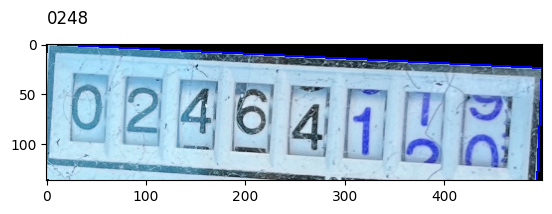

In [72]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img = cv.imread("ori.jpg")

# cut the image 1/3 and get the middle part
height, width, _ = img.shape

scale = 0.6
img = cv.resize(img, (int(width * scale), int(height * scale)))

height, width, _ = img.shape
print(height, width)

center_height = int(height // 4)
center_width = int(width // 4)

print(center_height, center_width)

cropped = img[
    center_height : int(center_height * 3.3),
    center_width : int(center_width * 3.3),
    :,
]

cropped_height, cropped_width, _ = cropped.shape

# cv.imshow("cropped", cropped)
# cv.waitKey(0)
# cv.destroyAllWindows()

gray = cv.cvtColor(cropped, cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(gray, (17, 17), 0)

minDist = gray.shape[0] / 8
param1 = 30
param2 = 50
minRadius = int(center_width * 0.1)
maxRadius = center_width

circle_img = cropped.copy()
circles = cv.HoughCircles(
    blurred,
    cv.HOUGH_GRADIENT,
    1,
    minDist,
    param1=param1,
    param2=param2,
    minRadius=minRadius,
    maxRadius=maxRadius,
)

# print(f"{len(circles)} circles detected", circles[0, :][0])
if circles is not None:
    circles = np.uint16(np.around(circles))  # type: ignore
    circles = circles[0, :]  # type: ignore
    circles = sorted(
        circles, key=lambda x: x[2], reverse=True
    )  # sort circles by radius in descending order
    largest_circle = circles[0]  # get the largest circle
    cv.circle(
        circle_img,
        (largest_circle[0], largest_circle[1]),
        largest_circle[2],
        (0, 255, 0),
        2,
    )

circle = largest_circle  # type: ignore
circle_center = (circle[0], circle[1])  # x, y
circle_radius = circle[2]

# recolor outside of the circle to black
mask = np.zeros((cropped_height, cropped_width), np.uint8)
cv.circle(mask, circle_center, circle_radius, 255, -1, 8, 0)  # type: ignore
masked = cv.bitwise_and(cropped, cropped, mask=mask)
masked[mask == 0] = 0

# crop the image
color_cropped = masked[
    circle_center[1] - circle_radius : circle_center[1] + circle_radius,
    circle_center[0] - circle_radius : circle_center[0] + circle_radius,
    :,
]

# cv.imshow("color_cropped", color_cropped)
# cv.waitKey(0)
# cv.destroyAllWindows()

# get the largest rectangle
gray = cv.cvtColor(cropped, cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(gray, (17, 17), 0)

canny = cv.Canny(blurred, 30, 150)

contours, _ = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) 
contours = sorted(contours, key=cv.contourArea, reverse=True)
largest_contour = contours[0]
rect = cv.minAreaRect(largest_contour)
box = cv.boxPoints(rect)
box = np.intp(box) # type: ignore
cv.drawContours(cropped, [box], 0, (0, 0, 255), 2) # type: ignore

# recolor the outside of the rectangle to black
mask = np.zeros((cropped_height, cropped_width), np.uint8)
cv.drawContours(mask, [box], 0, 255, -1) # type: ignore
masked = cv.bitwise_and(cropped, cropped, mask=mask)
masked[mask == 0] = 0

# crop the image
color_cropped = masked[
    box[1][1] : box[0][1], box[1][0] : box[2][0] # type: ignore
]

# OCR the image only detect a numbers
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

text = pytesseract.image_to_string(color_cropped, config="--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789")
print(text)

plt.imshow(color_cropped)
plt.text(0, 0, text, fontsize=12)
plt.show()
